In [40]:
!pip install pandas
!pip install geopandas
!pip install lxml
!pip install urllib
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib


     ---------------------------------------- 0.0/159.4 kB ? eta -:--:--
     -------------------------------------- 159.4/159.4 kB 9.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ------ --------------------------------- 1.1/7.6 MB 24.2 MB/s eta 0:00:01
   -------------- ------------------------- 2.8/7.6 MB 36.4 MB/s eta 0:00:01
   ----------------------- ---------------- 4.4/7.6 MB 31.6 MB/s eta 0:00:01
   ---------------------------- ----------- 5.5/7.6 MB 29.5 MB/s eta 0:00:01
   -------------------------------------- - 7.3/7.6 MB 31.1 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 28.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/186.7 kB ? eta -:--:--
   --------------------------------------- 186.7/186.7 kB 11.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------- -------------------- 1.1/2.2 MB 34.4 MB/s eta 0:00:01
   ----------------

In [41]:
import importlib
import pandas as pd
import requests
import geopandas as gpd
from os.path import isfile
import declarations as dec
import matplotlib

### Téléchargement des données de consommation d'électricité annuelle par adresse

In [3]:
def get_data_consumption(url, year, replace:bool = False):
    '''Gets the data of home's electricity consumption
    Args:
        url(string)
        year(string)
        replace(bool): True to replace consommation{year}.csv if it exists. Defaults to False.
    Returns:
        df (dataframe): dataframe of the home's electricity consumption for the wanted year 
    '''
    path_to_data="consommation"+f"{year}"+".csv"
    if (isfile(path_to_data) and not replace):
        df=pd.read_csv(path_to_data, sep=";")
    else:
        print("Chargement des données, cette étape peut prendre quelques minutes")
        response=requests.get(url)
        if response.status_code == 200:
            with open(path_to_data, "wb") as file:
                file.write(response.content)
            print("Téléchargement réussi.")
        else:
            print(f"Échec du téléchargement. Code d'état : {response.status_code}")
        df=pd.read_csv(path_to_data, sep=";")
    return df


In [1]:
# URL des bases de données à charger 

consumption_data_url_2018="https://enedis.opendatasoft.com/api/explore/v2.1/catalog/datasets/consommation-annuelle-residentielle-par-adresse/exports/csv?lang=fr&refine=annee%3A%222018%22&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
consumption_data_url_2019= "https://enedis.opendatasoft.com/api/explore/v2.1/catalog/datasets/consommation-annuelle-residentielle-par-adresse/exports/csv?lang=fr&refine=annee%3A%222019%22&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
consumption_data_url_2020="https://enedis.opendatasoft.com/api/explore/v2.1/catalog/datasets/consommation-annuelle-residentielle-par-adresse/exports/csv?lang=fr&refine=annee%3A%222020%22&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
consumption_data_url_2021="https://enedis.opendatasoft.com/api/explore/v2.1/catalog/datasets/consommation-annuelle-residentielle-par-adresse/exports/csv?lang=fr&refine=annee%3A%222021%22&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"

In [3]:
df_cons_2018=get_data_consumption(consumption_data_url_2018, "2018")
df_cons_2019=get_data_consumption(consumption_data_url_2019, "2019")
df_cons_2020=get_data_consumption(consumption_data_url_2020, "2020")
df_cons_2021=get_data_consumption(consumption_data_url_2021, "2021")

NameError: name 'consumption_data_url_2018' is not defined

### Récupération des données de Diagnostics de Performance Energétique (DPE)

In [4]:
def get_dpe_from_url(api_url):
    '''Imports a database from an API url.
    Args:
        api_url (string) : url of the wanted API
    Returns:
        pandas.DataFrame : dataframe
    '''
    req=requests.get(api_url)
    wb=req.json()
    df = pd.json_normalize(wb["results"])
    dpe = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs = 4326)
    dpe = dpe.dropna(subset = ['longitude', 'latitude'])
    return dpe

In [21]:
# Il est trop couteux de récupérer l'intégralité des données et nous ne disposons de données météo que pour
# certaines communes. L'idée est donc de ne récupérer les données de DPE que pour les communes voulues et de
# les agréger dans une unique table de données.

def get_dpe_dataset(api_root, communes):
    '''
    Args : 
    Returns : 
    '''


### Récupération des données de consommation annuelle d'électricité et gaz par département et par secteur d'activité

In [5]:
def get_data_consumption_department(df, year):
    '''Gets the data of the annual electricity consumption per "département" for a specific year
    Args:
        df (DataFrame)
        year(string)
    Returns:
        df (dataframe): dataframe of the home's electricity consumption for the wanted year 
    '''
    df_year= df[(df["Année"]==year) & (df["Filière"]=="Electricité")]
    return df_year


In [9]:
# Base de données 
cons_département="https://opendata.agenceore.fr/api/explore/v2.1/catalog/datasets/conso-elec-gaz-annuelle-par-secteur-dactivite-agregee-departement/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
df_cons_département=pd.read_csv(cons_département, sep=";")


In [24]:
variables_cons_département= ['Opérateur', 'Année', 'Filière', 
                             'Consommation Résidentiel  (MWh)', 'Nombre de points Résidentiel', 
                             'Nombre de mailles secretisées (résidentiel)','Indice qualité Résidentiel',
                             'Code Département', 'Libellé Département','Code Région', 'Libellé Région', 
                             'id_filiere', 'geom','Consommation totale (MWh)']
liste_département=pd.unique(df_cons_département["Libellé Département"])

['Aisne' 'Allier' 'Alpes-de-Haute-Provence' 'Hautes-Alpes' 'Aube' 'Aude'
 'Bouches-du-Rhône' 'Calvados' 'Cantal' 'Charente' "Côtes-d'Armor"
 'Creuse' 'Dordogne' 'Eure' 'Gers' 'Isère' 'Landes' 'Loir-et-Cher' 'Loire'
 'Lot' 'Lozère' 'Meuse' 'Orne' 'Pas-de-Calais' 'Puy-de-Dôme'
 'Pyrénées-Atlantiques' 'Hautes-Pyrénées' 'Bas-Rhin' 'Rhône'
 'Saône-et-Loire' 'Savoie' 'Tarn-et-Garonne' 'Var' 'Vendée' 'Haute-Vienne'
 'Hérault' 'Meurthe-et-Moselle' 'Alpes-Maritimes' 'Nord' 'Ariège'
 'Haute-Garonne' 'Haut-Rhin' 'Somme' 'Ardennes' "Côte-d'Or" 'Doubs'
 'Drôme' 'Loire-Atlantique' 'Haute-Marne' 'Morbihan' 'Sarthe'
 'Seine-Maritime' 'Seine-et-Marne' 'Tarn' 'Vaucluse' 'Vienne' 'Yonne'
 'Territoire de Belfort' 'Essonne' 'Hauts-de-Seine' 'Eure-et-Loir'
 'Finistère' 'Gard' 'Manche' 'Moselle' 'Haute-Saône' 'Paris'
 'Seine-Saint-Denis' 'Aveyron' 'Gironde' 'Pyrénées-Orientales'
 'Corse-du-Sud' 'Corrèze' 'Ille-et-Vilaine' 'Loiret' 'Lot-et-Garonne'
 'Maine-et-Loire' 'Deux-Sèvres' 'Ain' 'Ardèche' 'Cher' 'Indre

In [32]:
list_années=pd.unique(df_cons_département["Année"])
dico_cons_département={} # Création d'un dictionnaire qui à chaque année associe le dataframe de consommation d'électricité résidentielle par départements
dico_cons_tot={}
for année in list_années:
    if année not in dico_cons_département:
        df_année=get_data_consumption_department(df_cons_département, année)
        dico_cons_département[année]=dec.df_filter(df_année, variables_cons_département) # On sélectionne les variables dont on a besoin
        df_cons_tot=dico_cons_département[année].groupby(["Code Département","Libellé Département"])['Consommation Résidentiel  (MWh)'].sum().reset_index()
        dico_cons_tot[année]=df_cons_tot


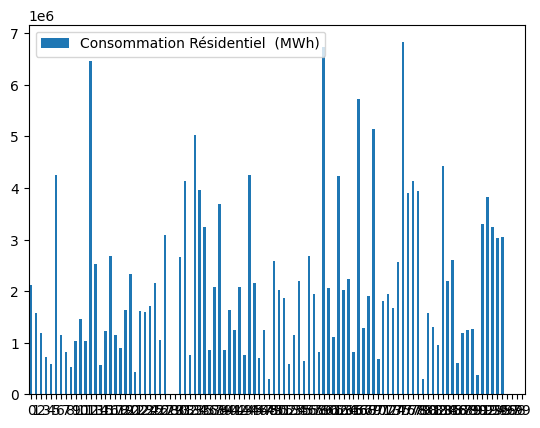

In [42]:
# Barplot de la consommation d'électricité du secteur résidentiel par département
ax=dico_cons_tot[2012].plot.bar(rot=0)